In [10]:
import pandas as pd
import h5py
import torch
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt

figure x

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
df = pd.read_csv('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/hsi_tensors/master.csv')
df = df.drop(['Unnamed: 0.1'], axis=1)
df = df.drop_duplicates()
df = df.drop(index=36)
df.dropna(subset=['taxonID_y'], inplace=True)
df['distance'] = df['distance'].astype(float)
df = df[df['taxonID_y'].map(df['taxonID_y'].value_counts()) >= 50]
df_litu = df[df['taxonID_y'] == 'LITU']
df = df.loc[df.groupby('geometry')['distance'].idxmin()]
df = pd.merge(df, df_litu, how='outer')
df = df[df['distance'] < 10]
df = df[df['taxonID_y'].map(df['taxonID_y'].value_counts()) >= 20]


# Define hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 200
taxonID_to_int = {taxonID: 0 if taxonID != 'LITU' else 1 for taxonID in df['taxonID_y'].unique()}
int_to_taxonID = {0: 'OTHER', 1: 'LITU'}
class ResizeToSize:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, data):
        data = data.float()
        data = nn.functional.interpolate(data.unsqueeze(0).unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False)
        return data.squeeze(0).squeeze(0)

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_size=(10, 10, 426), augment=True):
        self.dataframe = dataframe
        self.transform = ResizeToSize(target_size)
        self.augment = augment

        # Define augmentation transformations
        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=90),
        ])

    def __len__(self):
        return len(self.dataframe)

    def min_max_scale(self, data):
        # Perform min-max scaling on the data
        min_val = data.min()
        max_val = data.max()
        scaled_data = (data - min_val) / (max_val - min_val)
        return scaled_data

    def zscore_scale(self, data):
        # Perform z-score scaling on the data
        mean = data.mean()
        std = data.std()
        scaled_data = (data - mean) / std
        return scaled_data
    
    def zeroaware_scale(self, data):
        # Perform zero-aware scaling on the data
        nonzero_data = data[data != 0]
        mean = nonzero_data.mean()
        std = nonzero_data.std()
        scaled_data = data.clone()
        scaled_data[scaled_data != 0] = (nonzero_data - mean) / std
        np.clip(scaled_data, -1, 1)
        return scaled_data

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = f"/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/hsi_tensors/{row['siteID']}_{row['date']}_{row['adjEasting']}_{row['adjNorthing']}.h5"
        
        # Open the h5 file
        file = h5py.File(img_name, 'r')
        data = torch.from_numpy(file['subset'][:])
        file.close()

        # Apply resizing to the data
        data = self.transform(data)

        # Perform min-max scaling on the data
        # data = self.min_max_scale(data)

        # Swap the channel and x dimensions
        data = data.permute(2, 1, 0)

        if row['taxonID_y'] not in taxonID_to_int:
            label = torch.tensor(0)

        label = torch.tensor(taxonID_to_int[row['taxonID_y']])

        # Apply augmentation if enabled
        if self.augment:
            data = self.augmentation(data)
        return data, label.float()

dataset = CustomDataset(df)

/tmp/ipykernel_1909299/3857622419.py:15: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.merge(df, df_litu, how='outer')
/tmp/ipykernel_1909299/3857622419.py:15: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.merge(df, df_litu, how='outer')
/tmp/ipykernel_1909299/3857622419.py:15: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.merge(df, df_litu, how='outer')
/tmp/ipykernel_1909299/3857622419.py:15: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.merge(df, df_litu, how='outer')
/tmp/ipykernel_1909299/3857622419.py:15: FutureWarning: In a future 

In [28]:
band_dict_pos = {i: 0 for i in range(426)}
band_dict_neg = {i: 0 for i in range(426)}

for data in dataset:
    for band in range(426):
        band_avg = float(torch.mean(data[0][band,:,:]).detach().numpy())
    if data[1] == 1:
        band_dict_pos[band] += band_avg
    else:
        band_dict_neg[band] += band_avg

for band in range(426):
    band_dict_pos[band] = band_dict_pos[band]/len(band_dict_pos.items())
    band_dict_neg[band] = band_dict_neg[band]/len(band_dict_neg.items())

In [ ]:
df = pd.read_csv('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/hsi_tensors/master.csv')
df_positive = df[df['taxonID_y'] == 'LITU']
df_negative = df[df['taxonID_y'] != 'LITU']
band_dict_pos = {i: 0 for i in range(426)}

for row in df_positive.iterrows():
    file = row[1]['file']
    file = f'/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/hsi_tensors/{file}'
    file = h5py.File(file, 'r')
    data = file['subset'][:]
    file.close()
    for band in range(426):
        band_avg = mean(data[:,:, band])
        band_dict_pos[band] += band_avg
    
    for band in range(426):
        band_dict_pos[band] = band_dict_pos[band]/len(df_positive)


band_dict_neg = {i: 0 for i in range(426)}
for row in df_negative.iterrows():
    file = row[1]['file']
    file = f'/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/unknown_hsi_tensors/{file}'
    file = h5py.File(file, 'r')
    data = file['subset'][:]
    file.close()
    for band in range(426):
        band_avg = mean(data[:,:, band])
        band_dict_neg[band] += band_avg
    
    for band in range(426):
        band_dict_neg[band] = band_dict_neg[band]/len(df_negative)
    
    

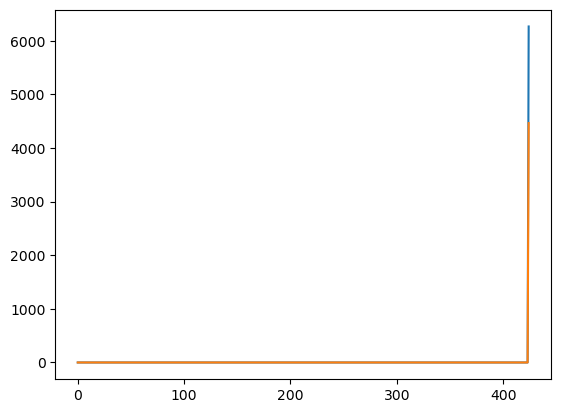

In [ ]:
x1 = []
y1 = []
x2 = []
y2 = []
for band in band_dict_pos:
    x1.append(band)
    y1.append(band_dict_pos[band])
    x2.append(band)
    y2.append(band_dict_neg[band])

plt.plot(x1, y1)
plt.plot(x2, y2)
# plt.yscale('log')

In [ ]:
data[:,:,1]

array([[841, 836, 750, 760, 777, 703],
       [708, 774, 843, 856, 697, 636],
       [776, 730, 784, 737, 717, 714],
       [748, 775, 701, 711, 735, 709],
       [676, 673, 751, 714, 737, 625],
       [738, 774, 781, 820, 826, 683],
       [754, 790, 774, 671, 675, 776]], dtype=int16)